# 2D Nuclear Segmentation with Multiple Semantic Heads

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.2 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

# Supported backbones:
# vgg16, vgg19
# densenet121, densenet169, densenet201
# mobilenet, mobilenetv2
# nasnet_large, nasnet_mobile
# resnet50
backbone = 'resnet50'

model_name = '{}_retinanet'.format(backbone)

n_epoch = 3  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

num_classes = 1  # "object" is the only class

## Create the RetinaNet Model

In [6]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))

In [7]:
from deepcell import model_zoo

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes=[1, 1],
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

Instructions for updating:
Use fn_output_signature instead


In [8]:
from deepcell.training import train_model_retinanet


model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=DATA_FILE,  # full path to npz file
    model_name=model_name,
    include_masks=True,
    panoptic=True,
    panoptic_weight=0.1,
    transforms=['inner-distance', 'outer-distance'],
    transforms_kwargs={},
    anchor_params=anchor_params,
    pyramid_levels=pyramid_levels,
    sigma=3.0,
    alpha=0.5,
    gamma=2.0,
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    compute_map=False,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (5760, 216, 256, 1)
y_train shape: (5760, 216, 256, 1)
X_test shape: (1440, 216, 256, 1)
y_test shape: (1440, 216, 256, 1)
Output Shape: (None, None, None, 1)
Number of Classes: 1
Training on 1 GPUs
Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   1/5162 [..............................] - ETA: 1s - loss: 6.1431 - regression_loss: 3.0898 - classification_loss: 2.2508 - masks_loss: 0.7030 - semantic_0_loss: 0.0457 - semantic_1_loss: 0.0539WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5162/5162 [==============================] - ETA: 0s - loss: 1.9577 - regression_loss: 1.3218 - classification_loss: 0.3309 - masks_loss: 0.3037 - semantic_0_loss: 3.1735e-04 - semantic_1_loss: 9.8667e-04
Epoch 00001: val_loss improved from inf to 1.62658, saving model to /data/models/resnet50_retinanet.h5
9853 instances of class 0 with average precision: 0.7894
mAP: 0.7894
5162/5162 [==============================] - 983s 190ms/step - loss: 1.9577 - regression_loss: 1.3218 - classification_loss: 0.3309 - masks_loss: 0.3

In [9]:
# Set up the prediction model
from deepcell import model_zoo

# Set up the prediction model
prediction_model = model_zoo.retinamask_bbox(
    model,
    nms=True,
    anchor_params=anchor_params,
    num_semantic_heads=2,
    panoptic=True,
    class_specific_filter=False)

Image Number: 913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


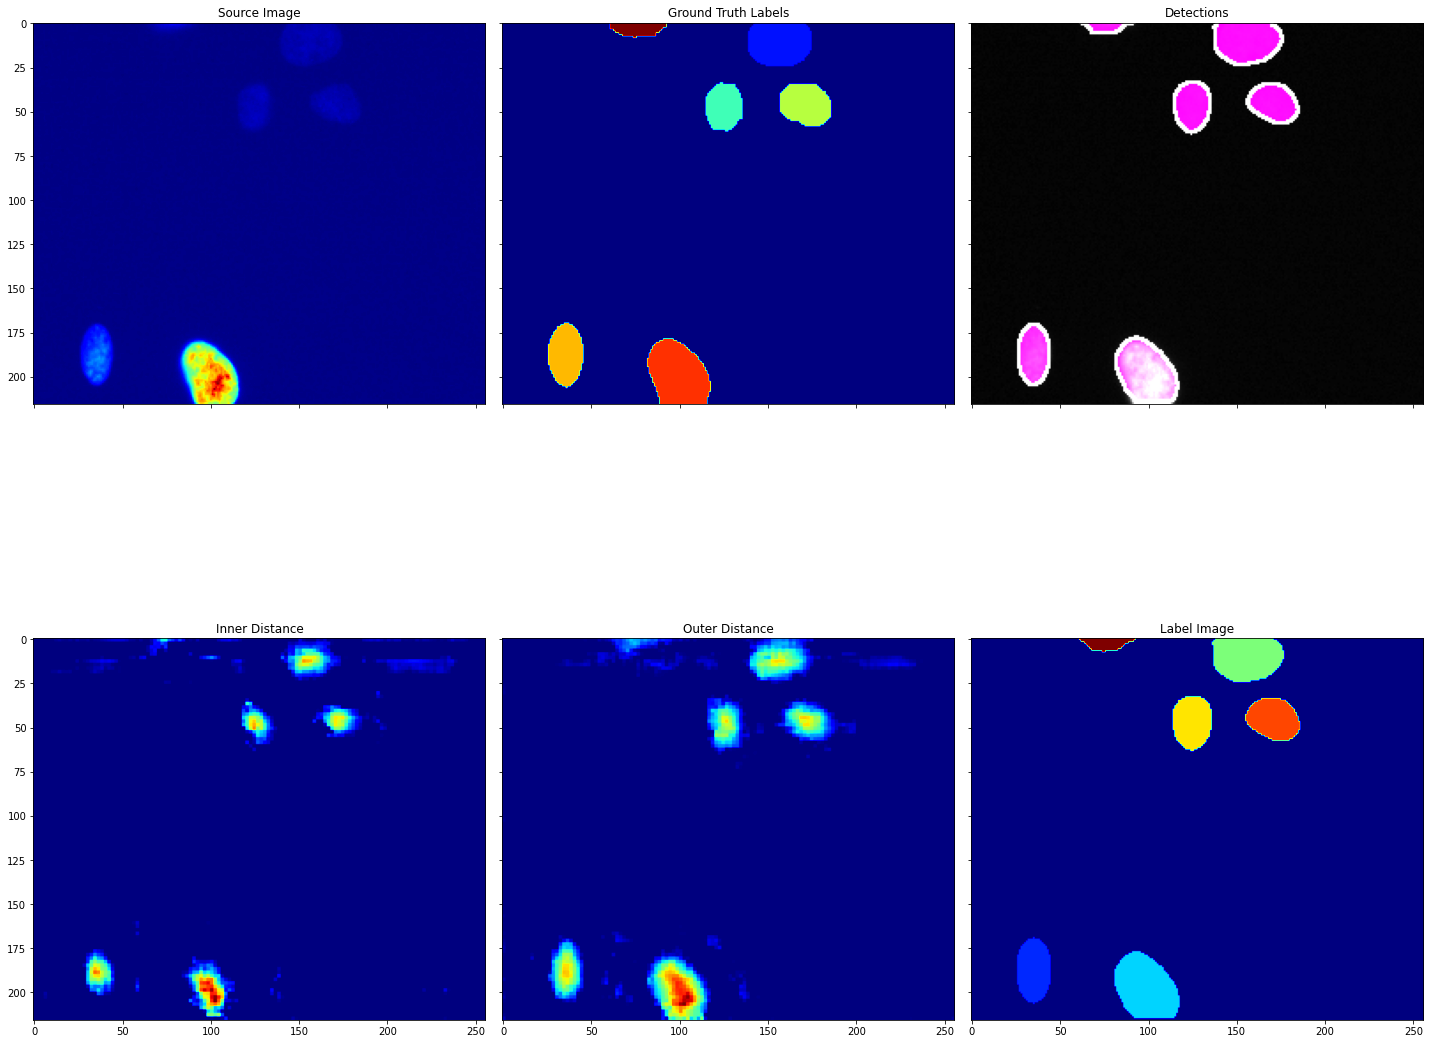

In [10]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from skimage.transform import resize 
from skimage.measure import label
from skimage.exposure import equalize_hist, rescale_intensity

from deepcell_toolbox import retinamask_semantic_postprocess
from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

results = prediction_model.predict(image)

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

boxes  = results[-6]
scores = results[-5]
labels = results[-4]
masks  = results[-3]
semantic = results[-2:]

label_image = retinamask_semantic_postprocess(results[:-1])

# copy to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0], score_threshold=0.5)

display_image = image.copy()
display_image = rescale_intensity(display_image, out_range=(-1, 1))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(display_image[..., -1], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

ax[3].imshow(semantic[0][0, ..., 0], cmap='jet')
ax[3].set_title('Inner Distance')
            
ax[4].imshow(semantic[1][0, ..., 0], cmap='jet')
ax[4].set_title('Outer Distance')

ax[5].imshow(label_image[0], cmap='jet')
ax[5].set_title('Label Image')

plt.tight_layout()
plt.show()